### Pipeline de treinamento de modelos

In [ ]:
!pip install fastparquet

from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import cv2
import pandas as pd
import numpy as np
import pickle

from matplotlib import pyplot as plt
from PIL import Image

### Divisao em treino - ETL

In [ ]:
X_test  = pd.read_parquet("/DataSet_treino_teste_testSize_05_seed20/X_test.parquet", engine='fastparquet')
y_train = pd.read_parquet("/DataSet_treino_teste_testSize_05_seed20/y_train.parquet", engine='fastparquet')
X_train = pd.read_parquet("/DataSet_treino_teste_testSize_05_seed20/X_train.parquet", engine='fastparquet')
y_test  = pd.read_parquet("/DataSet_treino_teste_testSize_05_seed20/y_test.parquet", engine='fastparquet')
df_original = pd.read_parquet("/FeatureExtraction_GS2500_maskOSM.parquet", engine='fastparquet')

## Modelagem
- lgbm 
- xgboost 
- decision tree
- random forest 
- MLP 


In [ ]:
 from sklearn.neural_network import MLPClassifier
 mlp = MLPClassifier()


model_nam = "MLP"              #----------------------> COLOQUE NOME AQUI
model = mlp.fit(X_train, y_train.values.ravel())

#salvar modelo
filename = '/Modelos salvos/'+ model_nam + '_fe_OSM.sav'
pickle.dump(mlp, open(filename, 'wb')) #--------------------> COLOQUE MODELO AQUI

In [ ]:
# from sklearn.neural_network import MLPClassifier
# mlp = MLPClassifier()


# model_nam = "mlp_v2"              #----------------------> COLOQUE NOME AQUI
# model = mlp.fit(X_train, y_train.values)

In [ ]:
# import lightgbm as lgbm
# LGBM = lgbm.LGBMClassifier(n_estimators=100,
#                           learning_rate=0.1,
#                           n_jobs= -1)
# #------------------------------------------------#

# model_nam = "LGBM"
# LGBM.fit(X_train, y_train)

# #salvar modelo
# filename = '/content/drive/MyDrive/TCC_IMG/Modelos salvos/'+ model_nam + '_fe_OSM.sav'
# pickle.dump(LGBM, open(filename, 'wb'))

Ler modelo salvo

In [ ]:
import pickle

filename = '/content/drive/MyDrive/TCC_IMG/Modelos salvos/LGBM_fe_OSM.sav'
loaded_model = pickle.load(open(filename, 'rb'))

In [ ]:
model = loaded_model #----------------------------------------> COLOQUE O MODELO AQUI
#model_nam = #####---------------------------------------> COLOQUE O NOME DO MODELO AQUI

import numpy as np
#predicao treinamento
prediction_train = model.predict(X_train)
#np.save('/content/drive/MyDrive/TCC_IMG/pred modelos nparray/prediction_train_'+ model_nam +"_fe_OSM", prediction_train)

#predicao teste
prediction_test = model.predict(X_test)
#np.save('/content/drive/MyDrive/TCC_IMG/pred modelos nparray/prediction_test_'+ model_nam + '_fe_OSM', prediction_test)

#predicao da imagem inteira
cols = ['Gaussian s7','Gaussian s3','Gabor23','Median s3','Scharr','Roberts','Gabor29','Original Image']
result = model.predict(df_original[cols])
#np.save('/content/drive/MyDrive/TCC_IMG/pred modelos nparray/resultado_'+ model_nam + '_fe_OSM', result)


## Métricas

In [ ]:
segmented = result.reshape((5000,5000))
from scipy.io import loadmat
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix


# imprimindo o relatório das métricas da classificação e a matriz de confusão
print(classification_report( y_train, prediction_train))
print(classification_report( y_test, prediction_test))
print(confusion_matrix( y_test, prediction_test))

              precision    recall  f1-score   support

           1       0.87      0.81      0.84    185500
           2       0.51      0.12      0.19   1432675
           3       0.83      0.95      0.88   2765265
           4       0.74      0.91      0.81   3165053

    accuracy                           0.77   7548493
   macro avg       0.74      0.70      0.68   7548493
weighted avg       0.73      0.77      0.72   7548493

              precision    recall  f1-score   support

           1       0.87      0.81      0.84    185459
           2       0.50      0.12      0.19   1432410
           3       0.83      0.95      0.88   2765153
           4       0.74      0.91      0.81   3165471

    accuracy                           0.77   7548493
   macro avg       0.74      0.69      0.68   7548493
weighted avg       0.73      0.77      0.72   7548493

[[ 149619     888    1128   33824]
 [   1387  170939  359147  900937]
 [      0   61526 2615781   87846]
 [  21248  105304  172977

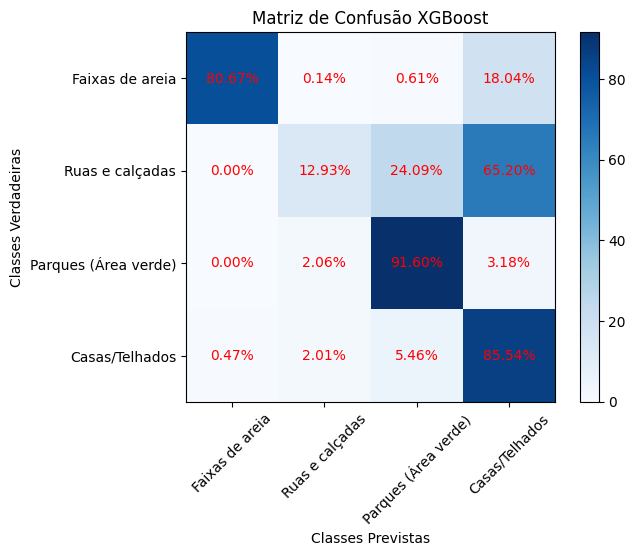

In [ ]:
cf = confusion_matrix( y_test, prediction_test)
cf_percent = cf.astype('float') / cf.sum(axis=1)[:, np.newaxis] * 100

# Rótulos das classes
class_labels = ['Faixas de areia', 'Ruas e calçadas', 'Parques (Área verde)', 'Casas/Telhados']

# Plot da matriz de confusão
plt.imshow(cf_percent, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()

# Configurações do gráfico
plt.title('Matriz de Confusão XGBoost')
plt.xlabel('Classes Previstas')
plt.ylabel('Classes Verdadeiras')
plt.xticks(np.arange(len(class_labels)), class_labels, rotation=45)
plt.yticks(np.arange(len(class_labels)), class_labels)

# Adição dos valores em porcentagem nas células da matriz
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        plt.text(j, i, f'{cf_percent[i, j]:.2f}%', ha='center', va='center', color='red')

# Exibição do gráfico
plt.show()

In [ ]:
#Máscara
mask_osm = "/content/drive/MyDrive/TCC_IMG/mask_polig_2500_2500_OSM_r05.tif"
truth = cv2.imread(mask_osm,0)
truth = truth.reshape(-1)

#Calculo da métrica IoU
from keras.metrics import MeanIoU
num_classes = 5
IOU_keras = MeanIoU(num_classes=num_classes)
IOU_keras.update_state(truth,result)
print("Mean IoU =", IOU_keras.result().numpy())


#I0U para cada classe
values = np.array(IOU_keras.get_weights()).reshape(num_classes, num_classes)
#print(values)

#Please verify the following code for correctness of IoU calculation
#I may have made some mistake in assigning the right values.
class1_IoU = values[1,1]/(values[1,1] + values[1,2] + values[1,3] + values[1,4] + values[2,1]+ values[3,1]+ values[4,1])
print("class1_IoU:", class1_IoU)
class2_IoU = values[2,2]/(values[2,2] + values[2,1] + values[2,3] + values[2,4] + values[1,2]+ values[3,2]+ values[4,2])
print("class2_IoU:", class2_IoU)
class3_IoU = values[3,3]/(values[3,3] + values[3,1] + values[3,2] + values[3,4] + values[1,3]+ values[2,3]+ values[4,3])
print("class3_IoU:", class3_IoU)
class4_IoU = values[4,4]/(values[4,4] + values[4,1] + values[4,2] + values[4,3] + values[1,4]+ values[2,4]+ values[3,4])
print("class4_IoU:", class4_IoU)

Mean IoU = 0.33139664
class1_IoU: 0.6841752
class2_IoU: 0.10217079
class3_IoU: 0.78050923
class4_IoU: 0.6794383


Plot máscara

In [ ]:
# Exportacao da imagem de satélite e máscara
# Imagem de satélite
img_gs = '/content/drive/MyDrive/TCC_IMG/GS_2500x2500_rs0.5.tif'
# Máscara
mask_osm = "/content/drive/MyDrive/TCC_IMG/mask_polig_2500_2500_OSM_r05.tif"

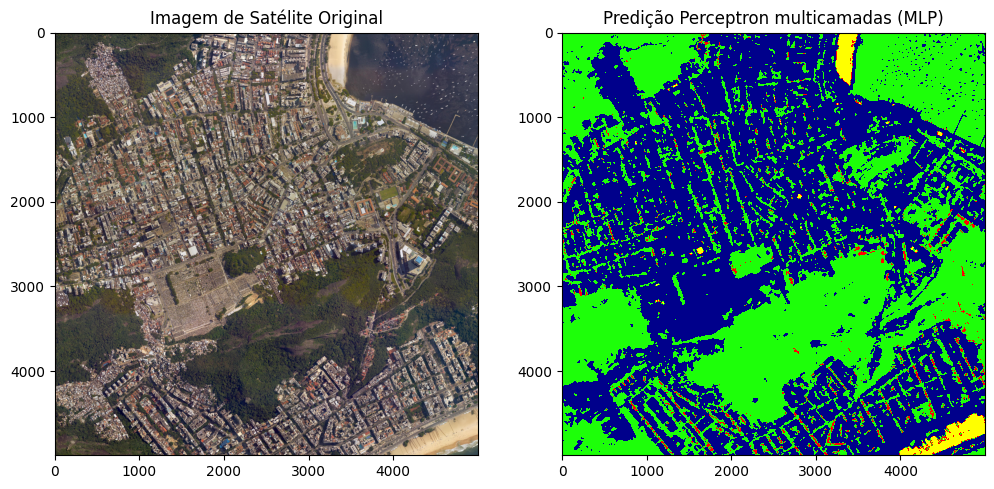

In [ ]:
from matplotlib.colors import ListedColormap
#{0: 'fundo', 1: 'faixa de areia', 2: 'ruas', 3: 'Áreas verdes', 4: 'casas'}
mapa_cores = { 1: 'yellow', 2: 'red', 3: '#1dff09ff', 4: 'darkblue'} #

# Criar uma lista de cores baseada no dicionário
lista_cores = [mapa_cores[x] for x in [1,2,3,4]]

# Criar um mapa de cores personalizado
cmap = ListedColormap(lista_cores)

#original_mask = cv2.imread(mask_osm,0)
img = cv2.imread(img_gs, 1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Criação da figura e dos subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

# Adicionando as imagens aos subplots
axs[0].imshow(img)
axs[0].set_title('Imagem de Satélite Original')

axs[1].imshow(segmented, cmap=cmap)
axs[1].set_title('Predição Perceptron + model_nam)

# Exibindo a figura
plt.show()